# Tutorial: Hydrogen Electro-Oxidation Reaction

## Introduction
 The microkinetic model of hydrogen electro-oxidation (**HOR**) proposed by Wang et al. [1]. is implemented here. The HOR global reaction is :
$$ \ce{H2 + Pt <--> 2 H+ + 2e-}  $$
The reaction mechanism is described by three elementary reaction steps
$$
\begin{align}
& \text{Dissociative adsortion} & \ce{H2 + 2 Pt <--> 2 H^{*}}  \tag{DA} \\
& \text{Oxidative adsorption} & \ce{H2 + Pt <--> H^{*} + H+ + e-}  \tag{OA} \\
& \text{Oxidative desorption} & \ce{H^{*} <--> Pt + H+ + e-}  \tag{OD}
\end{align}
$$

Wang et al. [1] analyzed the adsorption isotherms of H on adatom (Atop) sites and hollow/bridge (H/B) sites.

- **Atop sites**: These are positions where the adsorbed atom is located directly on a substrate atom (i.e., adsorption at a vertex position).
- **Hollow/Bridge (H/B) sites**:
  - *Hollow sites*: Located at the center of several substrate atoms, such as 3- or 4-coordinate sites in a crystal cell.
  - *Bridge sites*: Intermediate positions between two substrate atoms.


## Requirements

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from melektrodica import Collector, Calculator, Coordinator, Fitter, Kpynetic, Writer, Tool

def show_file(fname):
    with open(fname, "r") as f:
        file = f.read()
        print(file)

μElektrodica requires a **directory** containing tree input files:

In [2]:
directory = os.path.join("examples","Wang2007Hydrogen")

- **parameters.md file**: It contains operating and numeric parameters such as temperature, active catalyst surface area, initial and final potential, potential step size, and a description of the data provided

In [3]:
show_file(directory + "/parameters.md")

| Parameters                      | Variables                    | Value | Units |
|:--------------------------------|:-----------------------------|------:|:-----:|
| Electrode                       | Anode                        |  True |       |
| Physics parameters              | Temperature                  |    23 |   C   |
|                                 | Initial potential            |   0.0 |   V   |
|                                 | Final potential              |   0.5 |   V   |
|                                 | Step potential               | 0.001 |   V   |
| Continuous Stirred-Tank Reactor | Concentration = f(potential) | False |       |
|                                 | Catalyst Active surface area |   1.0 |  cm2  |
|                                 | Volumetric flux              |   1.0 |  L/s  |
| Rate Constants                  | --------------------------   |  ---- | ----  |
| Pre-exponential                 | A                            |     1 |       |
|   

- **species.md file** : Includes a list of species with their characteristics organized in columns: Species (name or identification), RPACe (role played by the species: **R**eactant, **P**roduct, **A**dsorbate, **C**atalyst, or **e**lectrical charge), c0 (initial concentrations), Catalyst (species on which it is adsorbed)  and other relevant properties. The column order is flexible, but the headers are essential.


In [4]:
show_file(directory + "/species.md")

| Species | RPACe | DG_formation |   c0 | Catalyst |
|---------|:-----:|-------------:|-----:|:---------|
| H2      |   R   |          0.0 |  1.0 |          |
| H+      |   P   |          0.0 |  1.0 |          |
| H*      |   A   |       -18e-3 |      | Pt       |
| Pt      |   C   |          0.0 |      |          |
| e-      |   e   |          0.0 |      |          |



- **reactions.md file** : It contains the list of reactions with their characteristics organized in columns. Maintaining the headers is crucial, as it ensures consistent nomenclature for the species across both the species and reaction files. The order of the columns itself is not important.

In [5]:
show_file(directory + "/reactions.md")

| id | Reactions                |     Ga | Beta |
|----|--------------------------|-------:|-----:|
| DA | H2 + 2Pt <-> 2H*         | 196e-3 |  0.0 |
| OA | H2 + Pt <-> H* + H+ + e- | 500e-3 |  0.5 |
| OD | H* <-> Pt + H+ + e-      | 290e-3 |  0.5 |



## Coverages factors
The **Collector** class allows for retrieving **data** from input files in **directory**. It is necessary to initialize **Kpynetic** with the retrieved **data** to ensure that functions and calculations, which are independent of the potential, can be properly initialized and executed. The **Calculator** module focuses on the numerical solution of the system of nonlinear equations that describe the steady state. This module provides the concentrations and coverage factors as functions of the potential.

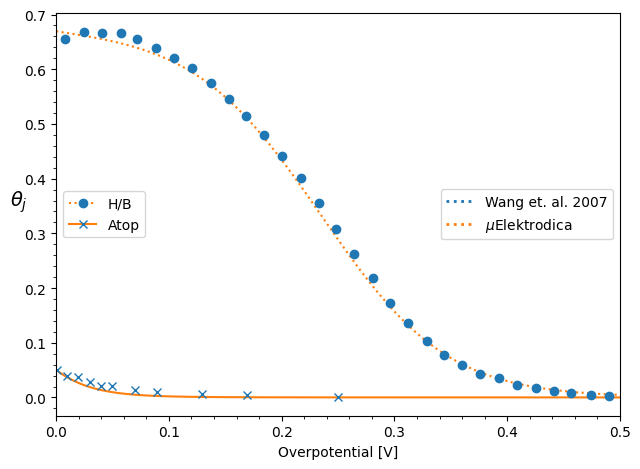

In [6]:
writer = Writer(log_file="Wang2007Hydrogen.log", log_directory=directory)
# H/B sites
data = Collector(directory)
Kpy = Kpynetic(data)
melek = Calculator(Kpy, 'hb' )
# Retrieving data from Wang et al. [1]
h_hb = pd.read_csv(directory + "/WangData/coverages_hb.csv", comment='#').values
j_hb = pd.read_csv(directory + "/WangData/current_hb.csv", comment='#').values

# Atop sites
data_atop = copy.deepcopy(data)
data_atop.species.g_formation_ads = np.array([75]) * 1e-3
data_atop.reactions.ga = np.array([196, 294, 48]) * 1e-3
Kpy_atop = Kpynetic(data_atop)
melek_atop = Calculator(Kpy_atop, 'atop')
# Retrieving data from Wang et al. [1]
h_atop = pd.read_csv(directory + "/WangData/coverages_atop.csv", comment='#').values
j_atop = pd.read_csv(directory + "/WangData/current_atop.csv", comment='#').values

coverages = {"H/B": ("o", ":", h_hb), "Atop": ("x", "-", h_atop)}
figname = os.path.join(directory, "WangHydrogen_theta.png")
plt.plot(melek.potential, melek.results.theta, linestyle=":", color="tab:orange")
plt.plot(melek.potential, melek_atop.results.theta, linestyle="-", color="tab:orange")
for label, (mark, linest, _data) in coverages.items():
    plt.plot(_data[:, 0], _data[:, 1], marker=mark, linestyle="", color="tab:blue")
plt.xlabel("Overpotential [V]")
plt.ylabel(r"$\theta_j$", rotation=0, fontsize=14)
plt.minorticks_on()
plt.tight_layout()
species_legend = [
    Line2D([0],[0], marker="o", markerfacecolor="tab:blue", markeredgecolor="tab:blue",
           linestyle=":", color="tab:orange", label=rf"H/B" ),
    Line2D([0],[0], marker="x", markerfacecolor="tab:blue", markeredgecolor="tab:blue",
           linestyle="-", color="tab:orange", label=rf"Atop"),
    ]
solutions_legend = [
    Line2D([0],[0], color="tab:blue", lw=2, linestyle=":", label="Wang et. al. 2007"  ),
    Line2D([0],[0], color="tab:orange", lw=2, linestyle=":", label=r"$\mu$Elektrodica"),
    ]
first_legend = plt.legend(handles=species_legend, loc="center left")
plt.gca().add_artist(first_legend)
plt.legend(handles=solutions_legend, loc="center right")
plt.tight_layout()
plt.xlim(0, 0.5)
plt.savefig(figname, dpi=300, bbox_inches="tight", format="png")
plt.show()

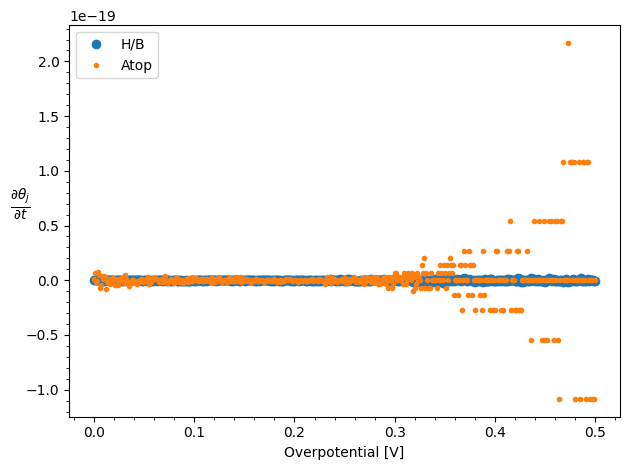

In [7]:
plt.plot(melek.potential, melek.results.fval, linestyle="", marker='.', markersize=12, color="tab:blue", label='H/B')
plt.plot(melek.potential, melek_atop.results.fval, linestyle="", marker='.', color="tab:orange", label='Atop')
plt.xlabel("Overpotential [V]")
plt.ylabel(r"$\frac{\partial \theta_j}{\partial t}$", rotation=0, fontsize=14)
plt.minorticks_on()
plt.tight_layout()
plt.legend()
plt.show()

In [8]:
writer.to_csv("coverages_hb", 'theta', melek)
writer.to_csv("current_hb", 'j', melek)
writer.to_csv("coverages_atop", 'theta', melek_atop)
writer.to_csv("current_atop", 'j', melek_atop)

Successfully written data to examples/Wang2007Hydrogen/MicroElektrodicaResults/coverages_hb.csv
Successfully written data to examples/Wang2007Hydrogen/MicroElektrodicaResults/current_hb.csv
Successfully written data to examples/Wang2007Hydrogen/MicroElektrodicaResults/coverages_atop.csv
Successfully written data to examples/Wang2007Hydrogen/MicroElektrodicaResults/current_atop.csv


## Polarization curve


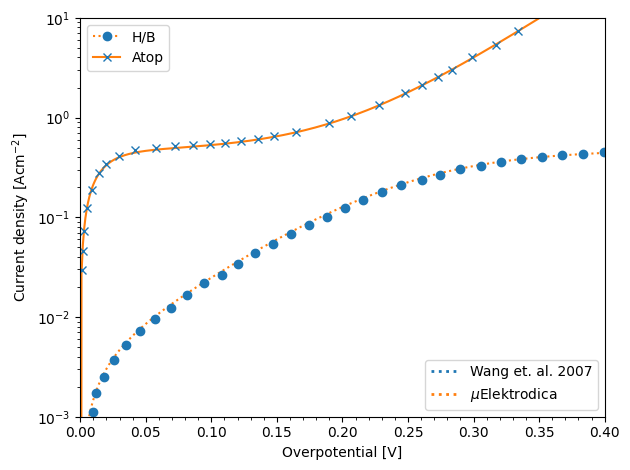

In [9]:
currents = {"H/B": ("o", ":", j_hb), "Atop": ("x", "-", j_atop)}
figname = os.path.join(directory, "WangHydrogen_j.png")
plt.plot(melek.potential, melek.results.j, linestyle=":", color="tab:orange")
plt.plot(melek_atop.potential, melek_atop.results.j, linestyle="-", color="tab:orange")
for label, (mark, linest, _data) in currents.items():
    plt.plot(_data[:, 0], _data[:, 1], marker=mark, linestyle="", color="tab:blue")
plt.ylabel(r"Current density [Acm$^{-2}$]")
plt.xlabel("Overpotential [V]")
plt.minorticks_on()
plt.tight_layout()
plt.yscale("log")
plt.ylim(1e-3, 10)
plt.xlim(0, 0.4)
first_legend = plt.legend(handles=species_legend, loc="upper left")
plt.gca().add_artist(first_legend)
plt.legend(handles=solutions_legend, loc="lower right")
plt.tight_layout()
plt.savefig(figname, dpi=300, bbox_inches="tight", format="png")
plt.show()

In [10]:
F = Fitter(Kpy, j_hb[:, 0], j_hb[:, 1], 'h/b')
print(f'Fitter Results for hollow/bridge sites\n'
      f'{writer.display_table('Reactions', F)}\n\n'
      f'{writer.display_table('Species', F)}\n')


Fitter Results for hollow/bridge sites
+-------------+--------------------------+
| Reactions   |   Activation energy [eV] |
+=============+==========================+
| DA          |                 0.196085 |
+-------------+--------------------------+
| OA          |                 0.480928 |
+-------------+--------------------------+
| OD          |                 0.29165  |
+-------------+--------------------------+

+-----------+-------------------------+
| Species   |   Formation energy [eV] |
+===========+=========================+
| H*        |              -0.0182442 |
+-----------+-------------------------+



In [11]:
F_atop = Fitter(Kpy_atop, j_atop[:, 0], j_atop[:, 1], 'atop')
print(f'Fitter Results for atop sites\n'
      f'{writer.display_table('Reactions', F_atop)}\n\n'
      f'{writer.display_table('Species', F_atop)}\n')

Fitter Results for atop sites
+-------------+--------------------------+
| Reactions   |   Activation energy [eV] |
+=============+==========================+
| DA          |                0.195169  |
+-------------+--------------------------+
| OA          |                0.294109  |
+-------------+--------------------------+
| OD          |                0.0441263 |
+-------------+--------------------------+

+-----------+-------------------------+
| Species   |   Formation energy [eV] |
+===========+=========================+
| H*        |                    0.09 |
+-----------+-------------------------+



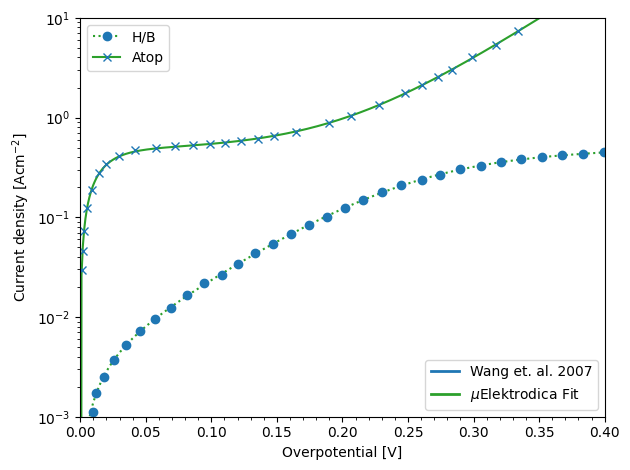

In [12]:
# H/B sites
fit = F.new_results(melek.potential)
# Atop sites
atop_fit = F_atop.new_results(melek_atop.potential)

currents = {"H/B": ("o", ":", j_hb), "Atop": ("x", "-", j_atop)}
figname = os.path.join(directory, "WangHydrogen_fit_j.png")
plt.plot(melek.potential, fit.results.j, linestyle=":", color="tab:green")
plt.plot(melek_atop.potential, atop_fit.results.j, linestyle="-", color="tab:green")
for label, (mark, linest, _data) in currents.items():
    plt.plot(_data[:, 0], _data[:, 1], marker=mark, linestyle="", color="tab:blue")
plt.ylabel(r"Current density [Acm$^{-2}$]")
plt.xlabel("Overpotential [V]")
plt.minorticks_on()
plt.tight_layout()
plt.yscale("log")
plt.ylim(1e-3, 10)
plt.xlim(0, 0.4)
species_legend = [
    Line2D([0],[0], marker="o", markerfacecolor="tab:blue", markeredgecolor="tab:blue",
           linestyle=":", color="tab:green", label=rf"H/B" ),
    Line2D([0],[0], marker="x", markerfacecolor="tab:blue", markeredgecolor="tab:blue",
           linestyle="-", color="tab:green", label=rf"Atop"),
    ]
solutions_legend = [
    Line2D([0],[0], color="tab:blue", lw=2, linestyle="-", label="Wang et. al. 2007"  ),
    Line2D([0],[0], color="tab:green", lw=2, linestyle="-", label=r"$\mu$Elektrodica Fit"),
    ]
first_legend = plt.legend(handles=species_legend, loc="upper left")
plt.gca().add_artist(first_legend)
plt.legend(handles=solutions_legend, loc="lower right")
plt.tight_layout()
plt.savefig(figname, dpi=300, bbox_inches="tight", format="png")
plt.show()

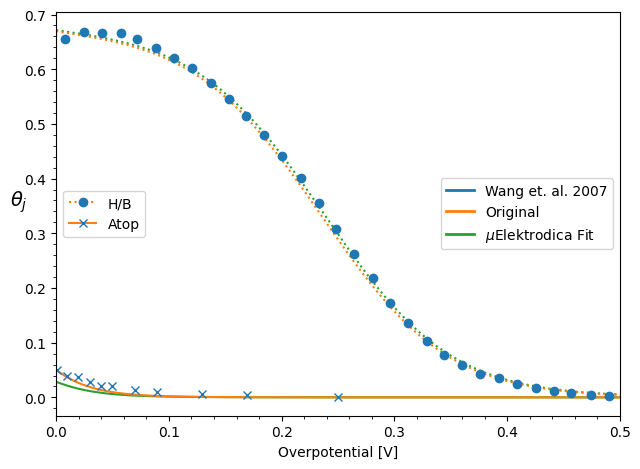

In [13]:
coverages = {"H/B": ("o", ":", h_hb), "Atop": ("x", "-", h_atop)}
figname = os.path.join(directory, "WangHydrogen_fit_theta.png")
plt.plot(melek.potential, fit.results.theta, linestyle=":", color="tab:green")
plt.plot(melek.potential, atop_fit.results.theta, linestyle="-", color="tab:green")
plt.plot(melek.potential, melek.results.theta, linestyle=":", color="tab:orange")
plt.plot(melek.potential, melek_atop.results.theta, linestyle="-", color="tab:orange")
for label, (mark, linest, _data) in coverages.items():
    plt.plot(_data[:, 0], _data[:, 1], marker=mark, linestyle="", color="tab:blue")
plt.xlabel("Overpotential [V]")
plt.ylabel(r"$\theta_j$", rotation=0, fontsize=14)
plt.minorticks_on()
plt.tight_layout()
species_legend = [
    Line2D([0],[0], marker="o", markerfacecolor="tab:blue", markeredgecolor="tab:blue",
           linestyle=":", color="tab:orange", label=rf"H/B" ),
    Line2D([0],[0], marker="x", markerfacecolor="tab:blue", markeredgecolor="tab:blue",
           linestyle="-", color="tab:orange", label=rf"Atop"),
    ]
solutions_legend = [
    Line2D([0],[0], color="tab:blue", lw=2, linestyle="-", label="Wang et. al. 2007"  ),
    Line2D([0],[0], color="tab:orange", lw=2, linestyle="-", label=r"Original"),
    Line2D([0],[0], color="tab:green", lw=2, linestyle="-", label=r"$\mu$Elektrodica Fit"),
    ]
first_legend = plt.legend(handles=species_legend, loc="center left")
plt.gca().add_artist(first_legend)
plt.legend(handles=solutions_legend, loc="center right")
plt.tight_layout()
plt.xlim(0, 0.5)
plt.savefig(figname, dpi=300, bbox_inches="tight", format="png")
plt.show()

## Free energy diagrams

Free energy diagram for H2 <--> H+


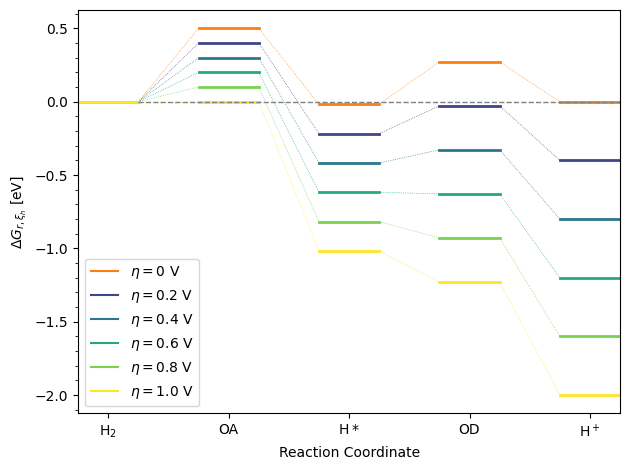

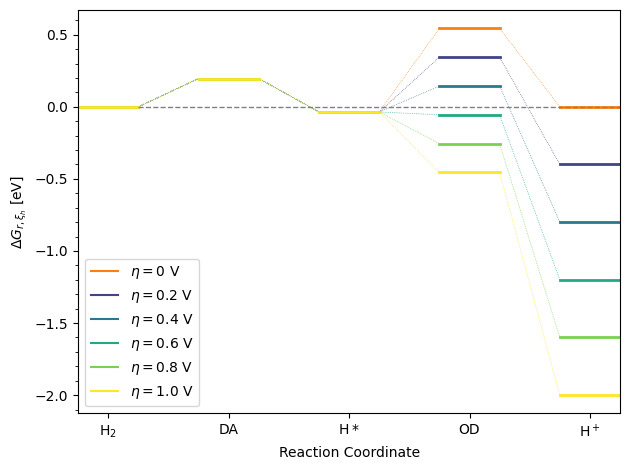

In [14]:
# H/B sites
source, target = ['H2', 'H+']
print(f'Free energy diagram for {source} <--> {target}')
overpotentials = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
fname = 'free_energy_diagram'
Coordinator(Kpy).plot_rxn_coords_potential(source, target, overpotentials, fname)


Free energy diagram for H2 <--> H+


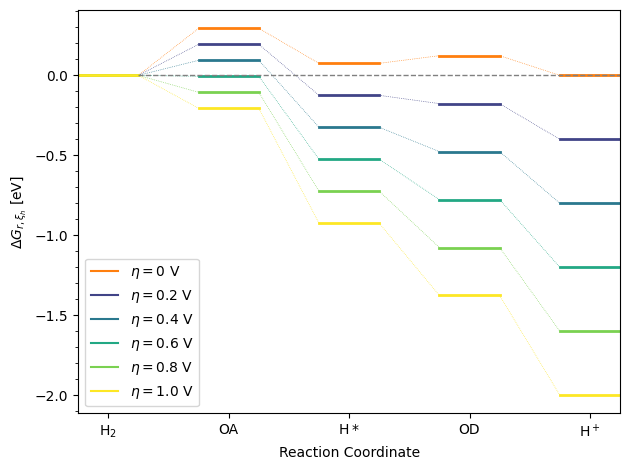

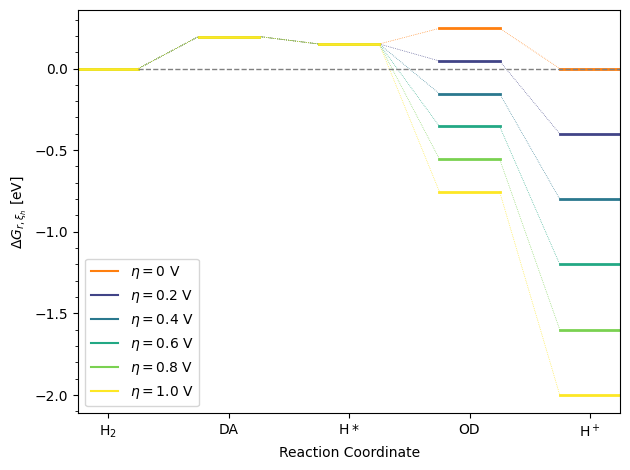

In [15]:
# Atop sites
source, target = ['H2', 'H+']
print(f'Free energy diagram for {source} <--> {target}')
overpotentials = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
fname = 'free_energy_diagram_atop'
Coordinator(Kpy_atop).plot_rxn_coords_potential(source, target, overpotentials, fname)

## References
1. Wang, J. X., Springer, T. E., Liu, P., Shao, M., and Adzic, R. R. (2007). Hydrogen oxidation reaction on Pt in acidic media: Adsorption isotherm and activation free energies. The Journal of Physical Chemistry C, 111(33), 12425-12433, https://doi.org/10.1021/jp073400i.